In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import csv
from pyspark.sql import SparkSession
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt 
from pyspark.sql.types import StructType, StructField, StringType
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()
import warnings
warnings.filterwarnings("ignore")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/24 12:46:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/09/24 12:46:31 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
df=spark.read.csv("stud.csv",header=True,inferSchema=True)

In [6]:
df.show()

+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|gender|race_ethnicity|parental_level_of_education|       lunch|test_preparation_course|math_score|reading_score|writing_score|
+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+
|female|       group B|          bachelor's degree|    standard|                   none|        72|           72|           74|
|female|       group C|               some college|    standard|              completed|        69|           90|           88|
|female|       group B|            master's degree|    standard|                   none|        90|           95|           93|
|  male|       group A|         associate's degree|free/reduced|                   none|        47|           57|           44|
|  male|       group C|               some college|    standard|                   none|        76|     

In [7]:
df.count()

1000

# Data checks to Perform

1.Check missin values
2.check duplicates
3.data types
4.unique values
5.statatics
6.Catrgorical 

In [11]:
from pyspark.sql.functions import col
for cols in df.columns:
    print(cols,df.where(col(cols).isNull()).count())

gender 0
race_ethnicity 0
parental_level_of_education 0
lunch 0
test_preparation_course 0
math_score 0
reading_score 0
writing_score 0


In [16]:
## No Missing Values are Present

In [12]:
df=df.dropDuplicates()

In [13]:
df.count()

1000

In [17]:
##No Duplicatesa are Present

In [14]:
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- race_ethnicity: string (nullable = true)
 |-- parental_level_of_education: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- test_preparation_course: string (nullable = true)
 |-- math_score: integer (nullable = true)
 |-- reading_score: integer (nullable = true)
 |-- writing_score: integer (nullable = true)



In [15]:
for i in df.columns:
    print(i,df.select(i).distinct().count())

gender 2
race_ethnicity 5
parental_level_of_education 6
lunch 2
test_preparation_course 2
math_score 81
reading_score 72
writing_score 77


In [20]:
df.describe().show()

+-------+------+--------------+---------------------------+------------+-----------------------+------------------+------------------+------------------+
|summary|gender|race_ethnicity|parental_level_of_education|       lunch|test_preparation_course|        math_score|     reading_score|     writing_score|
+-------+------+--------------+---------------------------+------------+-----------------------+------------------+------------------+------------------+
|  count|  1000|          1000|                       1000|        1000|                   1000|              1000|              1000|              1000|
|   mean|  null|          null|                       null|        null|                   null|            66.089|            69.169|            68.054|
| stddev|  null|          null|                       null|        null|                   null|15.163080096009452|14.600191937252209|15.195657010869656|
|    min|female|       group A|         associate's degree|free/reduced|    

In [39]:
df.select('gender').dtypes[0][1]

'string'

In [43]:
numerical_cols=[]
catorical_cols=[]
for cols in df.columns:
    (catorical_cols.append(cols) if df.select(cols).dtypes[0][1]=='string' else numerical_cols.append(cols))
df_num=df.select(numerical_cols)
df_cat=df.select(catorical_cols)

In [46]:
df_num.show(2)

+----------+-------------+-------------+
|math_score|reading_score|writing_score|
+----------+-------------+-------------+
|        62|           61|           57|
|        81|           88|           90|
+----------+-------------+-------------+
only showing top 2 rows



In [47]:
df_cat.show(2)

+------+--------------+---------------------------+--------+-----------------------+
|gender|race_ethnicity|parental_level_of_education|   lunch|test_preparation_course|
+------+--------------+---------------------------+--------+-----------------------+
|  male|       group B|               some college|standard|                   none|
|female|       group C|          bachelor's degree|standard|                   none|
+------+--------------+---------------------------+--------+-----------------------+
only showing top 2 rows



In [53]:
from pyspark.sql.functions import round
df=df.withColumn('Average',round((col('math_score')+col('reading_score')+col('reading_score'))/3,2))

In [54]:
df.show(3)

+------+--------------+---------------------------+--------+-----------------------+----------+-------------+-------------+-------+
|gender|race_ethnicity|parental_level_of_education|   lunch|test_preparation_course|math_score|reading_score|writing_score|Average|
+------+--------------+---------------------------+--------+-----------------------+----------+-------------+-------------+-------+
|  male|       group B|               some college|standard|                   none|        62|           61|           57|  61.33|
|female|       group C|          bachelor's degree|standard|                   none|        81|           88|           90|  85.67|
|female|       group C|         associate's degree|standard|                   none|        65|           76|           76|  72.33|
+------+--------------+---------------------------+--------+-----------------------+----------+-------------+-------------+-------+
only showing top 3 rows



In [55]:
df_pd=df.toPandas()

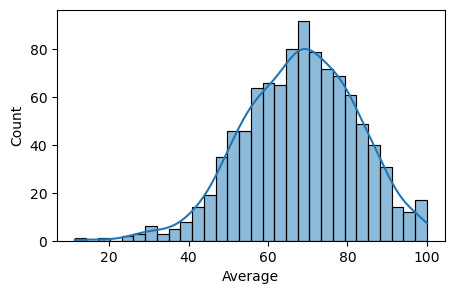

In [66]:
plt.figure(figsize=(5,3))
sns.histplot(df_pd.Average,kde=True,bins=30);

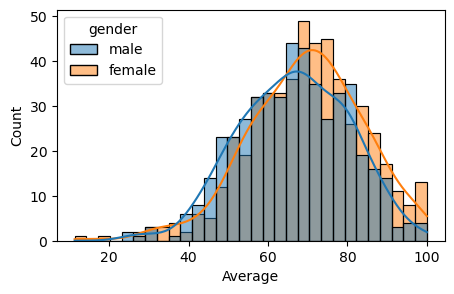

In [65]:
plt.figure(figsize=(5,3))
sns.histplot(data=df_pd ,x='Average',hue='gender',kde=True,bins=30);

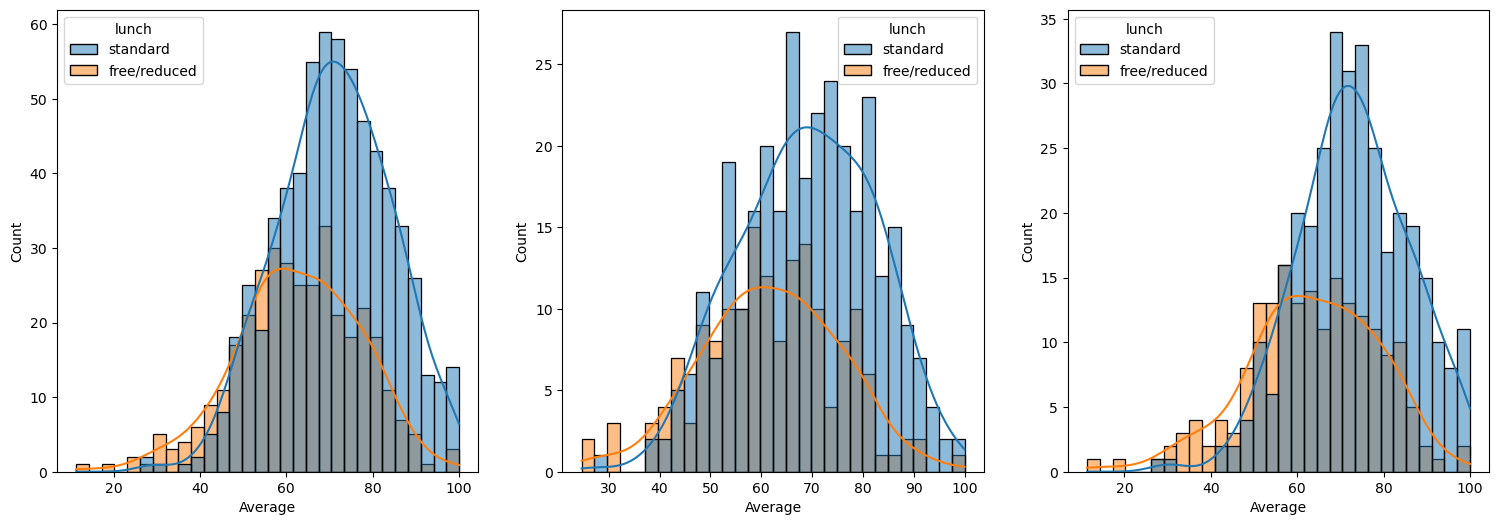

In [71]:
plt.subplots(1,3,figsize=(25,6))
plt.subplot(141)
sns.histplot(data=df_pd ,x='Average',hue='lunch',kde=True,bins=30);
plt.subplot(142)
sns.histplot(data=df_pd[df_pd['gender']=='male'] ,x='Average',hue='lunch',kde=True,bins=30);
plt.subplot(143)
sns.histplot(data=df_pd[df_pd['gender']=='female'] ,x='Average',hue='lunch',kde=True,bins=30);

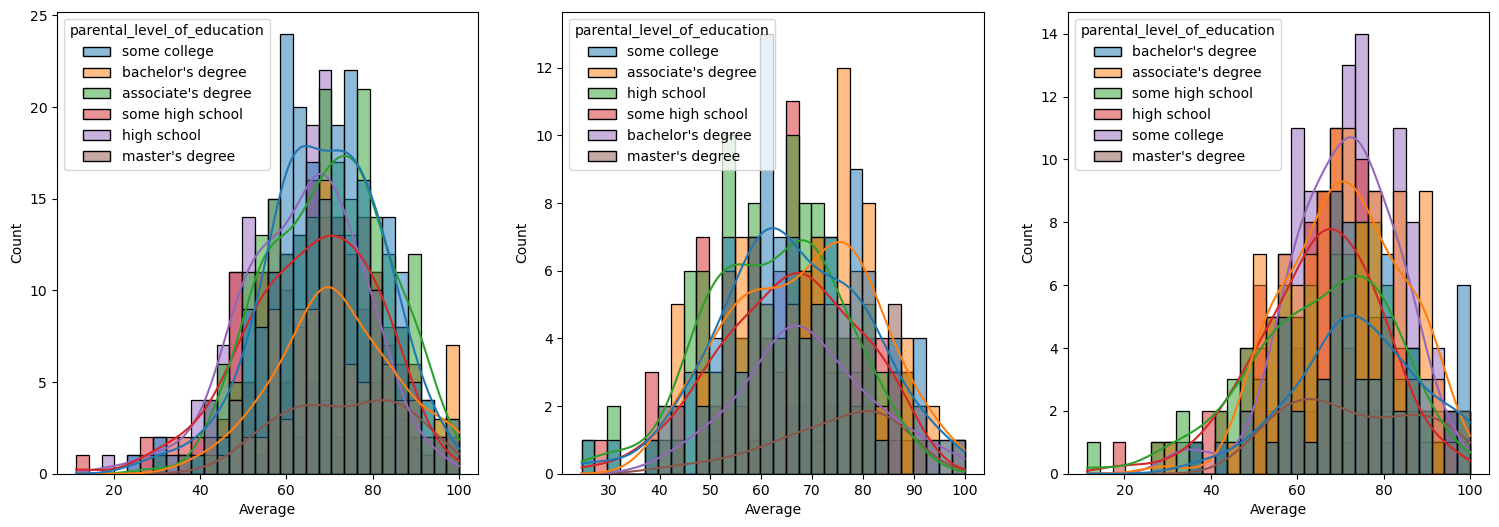

In [73]:
plt.subplots(1,3,figsize=(25,6))
plt.subplot(141)
sns.histplot(data=df_pd ,x='Average',hue='parental_level_of_education',kde=True,bins=30);
plt.subplot(142)
sns.histplot(data=df_pd[df_pd['gender']=='male'] ,x='Average',hue='parental_level_of_education',kde=True,bins=30);
plt.subplot(143)
sns.histplot(data=df_pd[df_pd['gender']=='female'] ,x='Average',hue='parental_level_of_education',kde=True,bins=30);

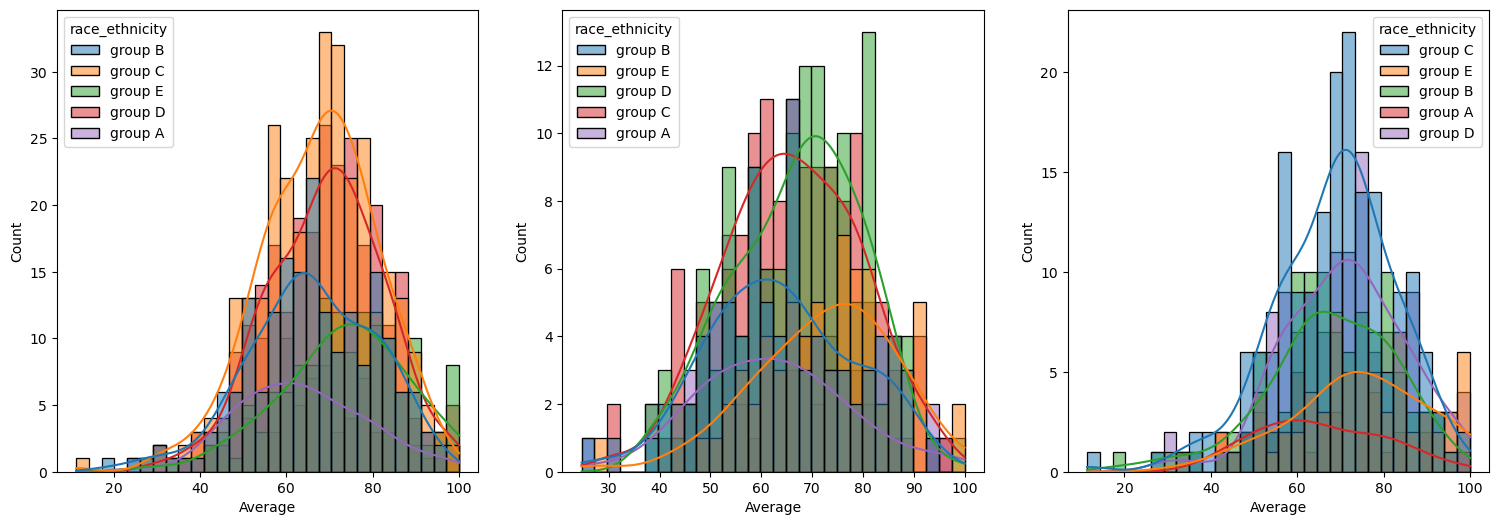

In [74]:
plt.subplots(1,3,figsize=(25,6))
plt.subplot(141)
sns.histplot(data=df_pd ,x='Average',hue='race_ethnicity',kde=True,bins=30);
plt.subplot(142)
sns.histplot(data=df_pd[df_pd['gender']=='male'] ,x='Average',hue='race_ethnicity',kde=True,bins=30);
plt.subplot(143)
sns.histplot(data=df_pd[df_pd['gender']=='female'] ,x='Average',hue='race_ethnicity',kde=True,bins=30);